In [2]:
import numpy as np
import tensorflow as tf
import os
import scipy.ndimage
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
tf.__version__

NameError: name 'tf' is not defined

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Dataset


In [3]:
def imread(path, index, scale=1, gray=True, is_train=False):
    if gray:
        image = np.zeros([len(index), image_y, image_x, 1])
        cnt=0
        for i in (index):
            if is_train:
                img = scipy.misc.imread(path+str(i).zfill(4)+'x'+str(scale)+'.png', flatten=True, mode='YCbCr').astype(np.float)/255.
            else:
                img = scipy.misc.imread(path+str(i).zfill(4)+'.png', flatten=True, mode='YCbCr').astype(np.float)/255.
            if img.shape[1]<img.shape[0]:
                img=img.T
            if is_train and img.shape[0]>=540:
                image[cnt,:,:,0]=preproc(img[:int(1080/scale),:int(1920/scale)], scale)
                cnt+=1
            elif is_train==False and img.shape[0]>=1080:
                image[cnt,:,:,0]=img[:int(1080/scale),:int(1920/scale)]
                cnt+=1
            
        return image[:cnt,:,:,:]
    else:
        image = np.zeros([len(index), image_y, image_x, 3])
        cnt=0
        for i in (index):
            if is_train:
                img = scipy.misc.imread(path+str(i).zfill(4)+'x'+str(scale)+'.png', mode='YCbCr').astype(np.float)/255.
            else:
                img = scipy.misc.imread(path+str(i).zfill(4)+'.png', mode='YCbCr').astype(np.float)/255.
            if img.shape[1]<img.shape[0]:
                img1=img[:,:,0].T
                img2=img[:,:,1].T
                img3=img[:,:,2].T
                img = np.stack([img1,img2,img3], axis=2)
            if is_train:
                image[cnt,:,:,:]=preproc(img[:int(1080/scale),:int(1920/scale),:],scale)
            else:
                image[cnt,:,:,:]=img[:int(1080/scale),:int(1920/scale),:]
            cnt+=1
        return image

In [4]:
def preproc(image, scale=2, gray=True):
    if gray:
        return scipy.ndimage.interpolation.zoom(image, (scale/1.), prefilter=False)
    else:
        image1 = scipy.ndimage.interpolation.zoom(image[:,:,0], (scale/1.), prefilter=False)
        image2 = scipy.ndimage.interpolation.zoom(image[:,:,1], (scale/1.), prefilter=False)
        image3 = scipy.ndimage.interpolation.zoom(image[:,:,2], (scale/1.), prefilter=False)
        imageA = np.stack([image1, image2, image3], axis=2)
        return imageA
    

In [5]:
def imsave(image, path):
    return scipy.misc.imsave(path, image)

# Networks

In [6]:
tf.reset_default_graph()
device = '/gpu:0'

In [7]:
gray=True
epoch_size = 1000
batch_size = 1
total_iter = 800/batch_size
image_x = 1920
image_y = 1080
if gray==True:
    c_dim=1
else:
    c_dim=3
    
learning_rate = 1e-3

        
with tf.device(device):
    X = tf.placeholder(tf.float32, [None, image_y, image_x, c_dim], name='input')
    Y = tf.placeholder(tf.float32, [None, image_y, image_x, c_dim], name='output')

    weights = {
        'w1' : tf.get_variable('w1',shape=[9,9,1,64], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'w2' : tf.get_variable('w2',shape=[1,1,64,32], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'w3' : tf.get_variable('w3',shape=[5,5,32,1], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d())            
    }
    biases = {
        'b1' : tf.get_variable('b1',shape=[64], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'b2' : tf.get_variable('b2',shape=[32], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'b3' : tf.get_variable('b3',shape=[1], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d())
    }

In [8]:
with tf.device(device):
    conv1 = tf.nn.relu(tf.nn.conv2d(X, weights['w1'], strides=[1,1,1,1], padding='SAME')+biases['b1'])
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1, weights['w2'], strides=[1,1,1,1], padding='SAME')+biases['b2'])
    conv3 = tf.nn.conv2d(conv2, weights['w3'], strides=[1,1,1,1], padding='SAME')+biases['b3']

    loss = tf.reduce_mean(tf.square(Y-conv3))
    optm = tf.train.AdamOptimizer(learning_rate).minimize(loss)



In [9]:
with tf.device(device):
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

In [ ]:
train_path='images/train_bicubic_x2/'
label_path='images/train_HR/'

In [ ]:
with tf.device(device):
    for epoch in range(epoch_size):
        avr_psnr = 0
        for i in range(total_iter):
            print i,
            index = np.random.choice(800, batch_size, replace=False)+1
            train_image = imread(path=train_path,index=index,is_train=True,scale=2)
            label_image = imread(path=label_path, index=index)
            
            sess.run(optm, feed_dict={X:train_image, Y:label_image})
            tr_loss = sess.run(loss, feed_dict={X:train_image, Y:label_image})
            psnr = 20*np.log10(1./np.sqrt(tr_loss))
            avr_psnr += psnr
            print psnr
        print ('epoch: %3d, Avr_PSNR: %4f' %(epoch, avr_psnr/total_iter))
        img = sess.run(conv3, feed_dict={X:train_image})
        for j in range(img.shape[0]):
            imsave(img[j,:,:,0], 'results/srcnn'+str(j).zfill(4)+'.png')
            imsave(train_image[j,:,:,0], 'results/interpol_'+str(j).zfill(4)+'.png')
        
    

0 9.07599749373
1 15.5936868913
2 23.0385539755
3 12.4568382426
4 12.4005504763
5 12.7577257802
6 13.3666428617
7 14.5424261333
8 13.6331930515
9 18.1662848327
10 14.1477650535
11 15.9418174264
12 13.5683509783
13 11.3179330128
14 15.4309753381
15 17.8395759568
16 21.6307547418
17 13.7737399221
18 18.1410716839
19 21.7258680401
20 19.6331722623
21 20.5980767619
22 21.7647302396
23 17.7284531247
24 21.9228951159
25 20.8941927533
26 21.9113392294
27 21.782064566
28 22.1947896987
29 20.4832931416
30 19.0518196739
31 24.2421150487
32 27.7681759636
33 24.5778953292
34 26.5075548629
35 21.627976304
36 26.7187882858
37 22.7160989492
38 27.6448420667
39 24.2842625222
40 28.8219764989
41 22.7329746936
42 24.0133799364
43 19.12909249
44 22.1230244096
45 23.8124670919
46 26.7307399187
47 28.0708736526
48 24.805186141
49 23.500553117
50 21.3339041336
51 25.7165546821
52 31.8181667619
53 26.0464471611
54 21.2369477707
55 22.508331565
56 23.3623840968
57 29.3712625218
58 23.7562135148
59 23.83026181

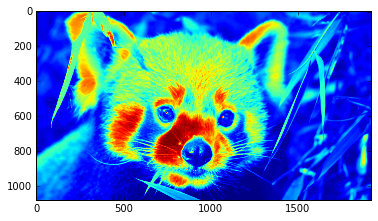

In [92]:
plt.imshow(train_image[3,:,:,0])

In [86]:
train_image.shape

(4, 1080, 1920, 1)

In [80]:
img[,:,:,0].shape

IndexError: index 1 is out of bounds for axis 0 with size 0

In [221]:
A=np.random.randint(800, size=10)
len(A)

10

In [220]:
for i in A:
    print i

726
456
773
221
75
479
230
470
590
533


In [111]:
psnr = 10*np.log10(255./2)
psnr

21.055101847699742

In [91]:
imageA.shape

(1356, 2040, 3)

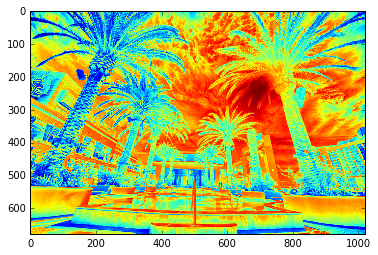

In [93]:
plt.imshow(image[:,:,0])

In [51]:
A=preproc('images/train_bicubic_x2/0001x2.png', 2, False)

In [52]:
A.shape

(4212, 2040)

In [48]:
imsave(A, 'results/A.png')

ValueError: 'arr' does not have a suitable array shape for any mode.

In [25]:
np.max(imageHR)

251.82099914550781

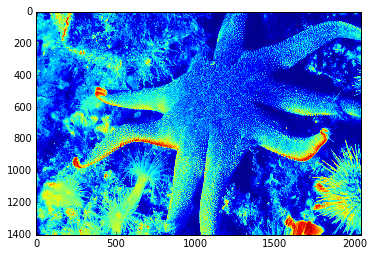

In [19]:
plt.imshow(imageHR)